In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('run_train_gan_g-tag-G_loss.csv')
df1.shape
df2 = pd.read_csv('run_train_gan_d-tag-D_loss.csv')
print(df2.head())
df = df1.merge(df2, on = 'Step')
df.Step = df.Step*100
df.head()
df.columns = ['Time x','Step','Discriminator','Time y','Generator']

      Wall time  Step      Value
0  1.511948e+09   224  -0.081318
1  1.511948e+09   992  -7.071727
2  1.511948e+09  1088 -10.946247
3  1.511948e+09  1440 -24.375620
4  1.511948e+09  1920 -28.817764


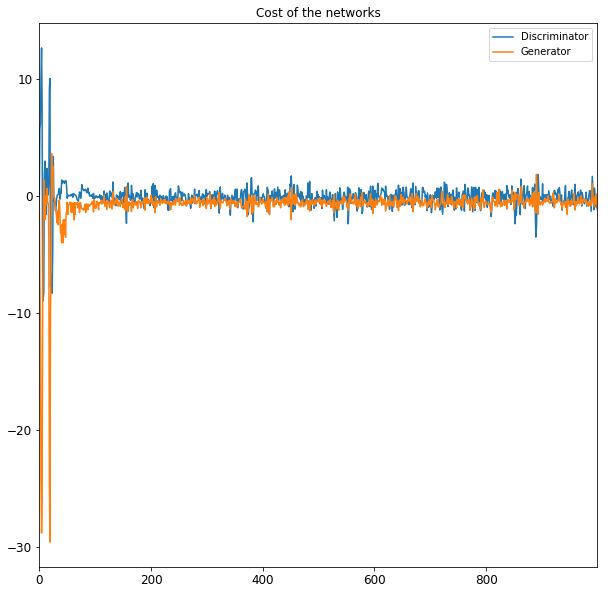

In [3]:
values_list = ['Value_x',"Value_y"]
df.iloc[:,[2,4]].plot(fontsize = 12,title = "Cost of the networks", figsize = [10,10])
plt.show()

In [4]:
import pickle
import numpy as np
with open('out/sample-0.pickle','rb') as f:
    data = pickle.load(f)
data = data.reshape(256*250,6)
#print(data.shape)
data_stack = np.hstack([np.zeros((256*250,3)),data,np.ones((256*250,2))])
df = pd.DataFrame(data = data_stack, columns = ['Unnamed: 0', 'Unnamed: 0.1', 'Time', 'Accelerometer_1',
       'Accelerometer_2', 'Accelerometer_3', 'Gyroscoop_1', 'Gyroscoop_2',
       'Gyroscoop_3', 'FOGnFOG', 'N_num'])
print(df.shape)
print(df.head())
df.to_csv('train_gan.csv')

(64000, 11)
   Unnamed: 0  Unnamed: 0.1  Time  Accelerometer_1  Accelerometer_2  \
0         0.0           0.0   0.0        -0.834825        -0.868819   
1         0.0           0.0   0.0        -0.756990        -1.271960   
2         0.0           0.0   0.0         1.511712         1.172938   
3         0.0           0.0   0.0        -0.573280         1.807767   
4         0.0           0.0   0.0         1.720923        -0.385603   

   Accelerometer_3  Gyroscoop_1  Gyroscoop_2  Gyroscoop_3  FOGnFOG  N_num  
0         1.138962     0.306518    -0.377088    -1.022714      1.0    1.0  
1         0.740851    -0.221647    -0.379542    -0.764096      1.0    1.0  
2        -0.521501     0.038943     0.654390     0.796808      1.0    1.0  
3        -0.886526     0.632086     0.952169    -2.156366      1.0    1.0  
4        -1.382528     0.875736     0.549520     0.666838      1.0    1.0  


In [5]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.contrib import rnn
import time
import io
import math
import os
from io import StringIO
sample_fq = 100
filename = 'timeserie_all_n_num.csv'

In [6]:
def enc(y,num = 3):
    y_ = np.zeros((y.shape[0],3))
    for i in range(y.shape[0]):
        y_[i,int(y[i])] = 1
    #print(np.sum(np.sum(y_)),np.sum(y))
    return(y_)
    
    
def reader(filename,ind,batchsize,lenght):
    done = False
    str_ = ''
    with open(filename) as f:
        
        str_ += next(f)
        i = 1
        try:
            while done is False:
                i +=1

                if i < ind:
                    _ = next(f)
                elif i <= ind + batchsize:
                    str_ += next(f)
                else:
                    #print("no error during reading file i:",i," ind:",ind," batchsize:",batchsize," length:",lenght)
                    done = True           
        except:
            print("Error during reading file i:",i," ind:",ind," batchsize:",batchsize," length:",lenght)
            return reader(filename,int(np.floor(np.random.rand(1)*(lenght-batchsize-1))),batchsize,lenght)
        
        return StringIO(str_)
class fog_data:
    def __init__(self,filename,window_length = 250, batch_size = 32, split = [0.7,0.15,0.15]):
        
        self.agl = range(3,9)[:]
        print(self.agl)
        self.window_length = window_length
        self.batch_size = batch_size
        self.filename = filename
        self.filename_training = filename[:-4] + "_training.csv"
        self.filename_val = filename[:-4] + "_val.csv"        
        self.filename_test = filename[:-4] + "_test.csv"
        self.filename_dict = {}
        self.len_ = {}
        self.filename_dict["training"] = self.filename_training
        self.split = [sum(split[0:i]) for i in range(1,len(split))]
        if not os.path.isfile(self.filename_test):
            self.split_dataset()
        else:
            self.len_["training"] = 9392263
        self.filename_gan = filename[:-4] + '_gan.csv'
        if not os.path.isfile(self.filename_gan):
            self.makegan()
        else:
            self.len_["gan"] = 1159500
            self.filename_dict["gan"] = self.filename_gan
            
            
        self.len_["training_gan"] = 64000
        self.filename_training_gan = "train_gan.csv"
        self.filename_dict["training_gan"] = self.filename_training_gan
        
    def makegan(self):        

        df = pd.read_csv(self.filename)
        print("full data shape",df.shape,np.sum(df.FOGnFOG.values))
        
        gandata = []
        i = 50
        print(df.head(),df.iloc[0:10,8])
        while i <= (df.shape[0]-200):
            if df.FOGnFOG[i] == 1:
                
                gandata.append(df.iloc[i-50:i+200,:].values)
                i+=200
                if i% 100 == 0:
                    print("just added an extra part to the file l:",len(gandata)," i:",i)
            i += 1
                
        print(len(gandata))
        np_df = np.array(gandata).reshape((-1,10))
        print(np_df.shape,df.shape,np_df.shape[0]/df.shape[0])
        df = pd.DataFrame(data=np_df,columns=df.columns)
        self.len_["gan"] = df.shape[0]
        self.filename_dict["gan"] = self.filename_gan
        df.to_csv(self.filename_gan)
             
    def next_batch(self,type_of_data = "training", batchsize = 32*250):
        
        size = self.len_[type_of_data]
        filen = self.filename_dict[type_of_data]
        if type_of_data == "training":
            divider = 1
        elif type_of_data == "gan":
            divider = 250
        elif type_of_data == "training_gan":
            divider = 250
            if np.random.rand() < .5:
                type_of_data == "training"
                print("going back to normal")
            else:
                print("keep beeing weird")
        
        ind = int(np.floor(np.random.rand(1)*(size-batchsize)/divider))
        df = pd.read_csv(reader(filen,ind*divider,batchsize,size))
        
        return self.return_data(df)
    
    def val(self):
        df = pd.read_csv(self.filename_val)
        return self.return_data(df,train = True)
    def test(self):
        df = pd.read_csv(self.filename_test)
        return self.return_data(df,train = False)
    

    def split_dataset(self):
        
        filenames = [self.filename_training,self.filename_val,self.filename_test]
        with open(self.filename,'r') as f:
            self.length = sum(1 for _ in f)
        with open(self.filename,'r') as f:
            self.split.append(self.length+1)
            self.split_i = np.floor([self.length * s for s in self.split])
            print(self.split_i)
            s = 0
            i = 0
            file = open(filenames[s],'w')
            for line in f:
                if i >= self.split_i[s]:
                    file.close()
                    s += 1
                    file = open(filenames[s],'w')
                    file.write(head)
                    print("switch to ",filenames[s])
                
                if i ==0:
                    head = line
                                        
                file.write(line)
                i +=1
                #print(i)
                
            file.close()
            print("splitted the data in different files according to ", [0, self.split_i, self.length])
            self.len_ = {}
            13417517
            self.len_["training"] = self.split_i[0]
            self.len_["val"], self.len_["test"] =  self.split_i[1] - self.split_i[0], self.length - self.split_i[1]
            
    def return_data(self,df,train = False): # include self.window_size
        acc_gyr = df.iloc[:,self.agl].values
        acc_gyr = (acc_gyr-np.mean(acc_gyr))/np.std(acc_gyr)
        num_windows = int(np.floor(np.divide(acc_gyr.shape[0],(self.window_length))))
        if acc_gyr.shape[0] - num_windows*self.window_length >1:
            print("through away something!!",acc_gyr.shape[0] - num_windows*self.window_length,acc_gyr.shape[0], num_windows*self.window_length)
            print(num_windows)
        a_g  = acc_gyr[:num_windows*self.window_length,:].reshape(num_windows,self.window_length,6)
        
        fog = df.FOGnFOG[:num_windows*self.window_length].values
        fog_reshape = fog.reshape(num_windows,self.window_length,1)
        fognfog = np.mean(fog_reshape,axis=1)
        if np.random.rand() < 0.95 and train:
            inx = np.random.randint(0,high=a_g.shape[0])
            a_g[inx,:,:] = (np.random.rand(a_g[inx,:,:].shape[0],a_g[inx,:,:].shape[1])*2-1)*a_g[inx,:,:]
            fognfog[inx,:] = 2
        
        
        return a_g, np.round(fognfog[:,0]), fognfog
    

fog = fog_data(filename)
acc, fog_, fogi = fog.next_batch()
a, f, fi = fog.next_batch("gan")
for _ in range(10):
    a, f, fi = fog.next_batch("training_gan")
print(acc.shape, fog_.shape," ee ", fogi.shape ,a.shape,f.shape,fi.shape)

range(3, 9)
keep beeing weird
keep beeing weird
keep beeing weird
going back to normal
keep beeing weird
going back to normal
keep beeing weird
keep beeing weird
keep beeing weird
going back to normal
(32, 250, 6) (32,)  ee  (32, 1) (32, 250, 6) (32,) (32, 1)


In [7]:
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
def geomean_cost(y_true, y_pred, extra_incentive = True, incl_accuracy = True, extra_incentive_value = 0.7):
    """Compute geomean_cost to evaluate the accuracy of a classification
    By definition the geomean is :math:`sqrt(sensitifity*specificity)`.
    This function adds an extra incentive to improve if either the sensitivity or 
    the specificity is lower than extra_incentive_value ( default = 0.7).
    If incl_accuracy then it will return -accuracy if geomean is 0.
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
   extra_incentive : bool, default: True
       extra_incentive will punch more if sensitifity 
       or specificity is below extraincentivevalue.
   incl_accuracy : bool, default: True
       Will return - accuracy if geomean <=0
   extra_incentive_value:  float, default: 0.7
       The threshold for the extra incentive to start
       punishing if either sensitifity or specificity is
       lower than this value. This number must be between 0 and 1.
    Returns
    -------
    cost : float
        cost
    """
    if extra_incentive_value >= 1 or extra_incentive_value <= 0:
        error()    
    from sklearn.metrics import confusion_matrix
    c = confusion_matrix(y_true, y_pred)
    sens = c[1,1]/np.sum(c[1,]) # TP/(TP+FN)
    spec = c[0,0]/np.sum(c[0,]) # TN/(TN+FP)
    geomean = np.sqrt(sens*spec)
    cost = geomean
    if extra_incentive:
        if sens < extra_incentive_value: 
            cost *= (sens+0.3)
        if spec < extra_incentive_value:
            cost *= (spec+0.3)
    if cost <= 0 and incl_accuracy:
        cost = -1 + np.divide(np.sum(c[0,0],c[1,1]),np.sum(c)) # (TP + TN)/(TP + FN + TN + FP)
    return cost
geo_cost = make_scorer(geomean_cost,greater_is_better=True)

through away something!! 128 2012628 2012500
8050
normal
(8050, 1)
1
             precision    recall  f1-score   support

       nFOG       1.00      1.00      1.00      7948
        FOG       0.82      1.00      0.90       102

avg / total       1.00      1.00      1.00      8050

Cost:	:0.9986150449759608


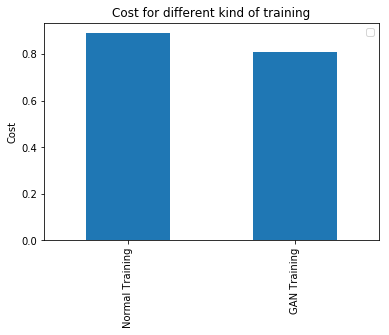

In [15]:
df_test = pd.read_csv('timeserie_all_n_num_test.csv')
_, fognfog, _ = fog.return_data(df_test)
fognfog = np.array(fognfog).reshape((-1,1))

ytest_normal, _ = np.array(pickle.load(open('ytest_normal.pickle','rb')))
ytest_gan = np.array(pickle.load(open('ytest_normal.pickle','rb')))
def results(y_test):
    y_test = y_test.T
    ind = np.where(ytest_normal == 2)
    print(fognfog.shape)
    print(len(ind))
    y_test[ind,0] = 0
    fognfog[ind,0] = 0
    print(classification_report(fognfog > .5, y_test >.5, target_names=["nFOG","FOG"],))
    cost = geomean_cost(fognfog, y_test)
    print("Cost:\t:{0}".format(cost))
    return cost
print("normal")
normal = results(np.array(ytest_normal))
normal = 0.89
gan = 0.81
df_results = pd.DataFrame(data = [[normal],[gan]],index = ["Normal Training", 'GAN Training'])
df_results.plot(kind='bar')
plt.ylabel('Cost')
plt.title('Cost for different kind of training')
plt.legend([])
plt.colors = ['r','b']

plt.show()